## Imports and Functions 

First we import all the libraries and functions to carry out the experiments. The functions include an adapted version fo the library ICPy[] and all the functions necesaries to implement and evaluate our method including *build_tree, check_ICP, build_causal_graph,build_causal_graph_multiple_covariates, plot_graph and get_metrics.*

In [2]:
!pip install causal-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 173 kB 34.1 MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats.stats import pearsonr
import itertools
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits import mplot3d
import statsmodels.api as sm
import scipy.stats
from scipy import stats
from scipy.stats import ks_2samp, ttest_ind
import math
from collections import Counter, namedtuple
import itertools as it
#from google.colab import files
import networkx as nx
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import tree
from causallearn.search.FCMBased import lingam
from causallearn.search.ConstraintBased.FCI import fci
#import icpy
import warnings
warnings.filterwarnings('ignore')



In [4]:
def build_tree(lev, input, output, df):
  inputs = [input]
  output = output
  if (df[output].dtype==int)&(len(df[output].unique())==2):
      output_type='binary'
  elif (df[output].dtype==int)&(len(df[output].unique())>2):
      output_type='multiclass'
  else:
      output_type='continuous'

  if output_type == 'continuous':
    regr = DecisionTreeRegressor(criterion = 'absolute_error',max_depth= lev,  random_state=0 )#, min_samples_leaf=0.10, splitter='random',splitter='random',criterion = 'absolute_error',
  else:
    regr = DecisionTreeClassifier(criterion ='entropy', max_depth= lev, random_state=0)#
  model = regr.fit(df[inputs], df[output])
  s = regr.tree_.threshold
  s = s[s!=-2]
  ce = 'e4_'+input
  splits = []
  if len(s)==1:
    s1 = s[0]
    splits.append(s1)
    df[ce] = np.zeros(len(df)) 
    df.loc[(df[input]<= s1),ce] = 1

  elif len(s)==2:
    s1, s2 = min(s), max(s)
    splits.append([s1,s2])
    df[ce] = np.zeros(len(df)) 
    df.loc[(df[input]<= s1),ce] = 1
    df.loc[(df[input]>s1)&(df[input]<=s2),ce] = 2
    df.loc[(df[input]>=s2),ce] = 3
    
  elif len(s)==3:
    s1, s2, s3 = s[1], s[0], s[2]
    splits.append([s1,s2,s3])
    df[ce] = np.zeros(len(df)) 
    df.loc[(df[input]<= s1),ce] = 1
    df.loc[(df[input]>s1)&(df[input]<=s2),ce] = 2
    df.loc[(df[input]>=s2)&(df[input]<s3),ce] = 3
    df.loc[(df[input]>s3),ce] = 4
  elif lev==3:
    s1, s2, s3, s4, s5, s6, s7 = regr.tree_.threshold[2], regr.tree_.threshold[1], regr.tree_.threshold[0], regr.tree_.threshold[5],\
            regr.tree_.threshold[9],regr.tree_.threshold[8],regr.tree_.threshold[12]
    splits.append([s1,s2,s3, s4, s5, s6, s7])
    ce = 'e8_'+input
    df[ce] = np.zeros(len(df)) 
    df.loc[(df[input]<= s1),ce] = 1
    df.loc[(df[input]>s1)&(df[input]<=s2),ce] = 2
    df.loc[(df[input]>=s2)&(df[input]<s3),ce] = 3
    df.loc[(df[input]>=s3)&(df[input]<s4),ce] = 4

    df.loc[(df[input]>s4)&(df[input]<=s5),ce] = 5
    df.loc[(df[input]>=s5)&(df[input]<s6),ce] = 6
    df.loc[(df[input]>=s6)&(df[input]<s7),ce] = 7
    df.loc[(df[input]> s7),ce] = 8
  else:
    print('no level detected')
  return df


def all_parent_sets(S, max_num_parents):
    return it.chain.from_iterable(
        it.combinations(S, n_parents) for n_parents in range(min(len(S), max_num_parents) + 1))


def f_test(x1, x2):
    """
    Perform F-test for equal variance.
    """
    F = np.var(x1, ddof=1) / np.var(x2, ddof=1)
    return 2 * min(scipy.stats.f.cdf(F, len(x1) - 1, len(x2) - 1), scipy.stats.f.sf(F, len(x1) - 1, len(x2) - 1))


def test_plausible_parent_set(X, y, z, method = 'continuous'):
    n_e = len(np.unique(z))
    environments = np.unique(z)

    if method=='continuous':
      lm = sklearn.linear_model.LinearRegression(fit_intercept=False)
    elif method=='binary':
      lm = sklearn.linear_model.LogisticRegression(fit_intercept=False)
    else:
      lm = sklearn.linear_model.LogisticRegression(fit_intercept=False, multi_class='multinomial', solver='lbfgs')

    X_with_intercept = np.hstack((X, np.ones((X.shape[0], 1))))
    lm.fit(X_with_intercept, y)
    residuals = lm.predict(X_with_intercept) - y

    return min([2 * min(scipy.stats.ttest_ind(residuals[np.equal(z, e)],
                                              residuals[np.logical_not(np.equal(z, e))],
                                              equal_var=False).pvalue,
                        f_test(residuals[np.equal(z, e)],
                               residuals[np.logical_not(np.equal(z, e))]))
                for e in environments]) * n_e



def preselect_parents(X, y, n):
    _, selected, _ = sklearn.linear_model.lars_path(X, y, method='lasso', max_iter=n, return_path=False)
    return selected

ICP = namedtuple("ICP", ["S_hat", "q_values", "p_value"])
def invariant_causal_prediction(X, y, z,alpha=0.1, method='continuous'):# e2,

    n = X.shape[0]
    p = X.shape[1]
    max_num_parents =9

    S_0 = list(range(p))
    q_values = np.zeros(p)
    p_value_model = 0
    all_sets = all_parent_sets(S_0, max_num_parents)
    S_list = [x for x in all_sets]
    for S in all_parent_sets(S_0, max_num_parents):
        not_S = np.ones(p, bool)
        not_S[list(S)] = False
        p_value = test_plausible_parent_set(X[:, S], y, z, method)

        q_values[not_S] = np.maximum(q_values[not_S], p_value)
        p_value_model = max(p_value_model, p_value)

    q_values = np.minimum(q_values, 1)
    S_hat = np.where(q_values <= alpha)[0]
    return ICP(S_hat, q_values, p_value_model)



def check_ICP(df, inputs, output, e_list):
  X = df[inputs].values
  y = df[output].values
  l = []
  for ce in e_list:

      if (df[output].dtype==int)&(len(df[output].unique())==2):
          output_type='binary'
      elif (df[output].dtype==int)&(len(df[output].unique())>2):
          output_type='multiclass'
      else:
          output_type='continuous'

      s, q ,p = invariant_causal_prediction(X=X, y=y, z=df[ce], method=output_type)
      result = list(np.array(inputs)[s.astype(int)])
      if (len(result)==1):
        if (result[0]==str(ce)[3:]): 
              l.append(result[0])
  
  causal_parents = [(output, parent) for parent in l]
  return causal_parents


def build_causal_graph(df, plot=False):    
    inputs = df.columns.values
    level = 2
    causal_parents_final = []
    for i in range(len(inputs)):
        output = inputs[i]
        new_inputs = list(inputs[inputs  != output])
        e_list =['e4_'+var for var in new_inputs]
        for input in new_inputs:
                    df = build_tree(level, input, output, df)
        causal_parents = check_ICP(df,new_inputs, output, e_list)
        causal_parents_final.append(causal_parents)
    causal_parents_final = [item for sublist in causal_parents_final for item in sublist]

    if plot:
        plot_graph(causal_parents_final)
    return causal_parents_final
    
      


def build_causal_graph_multiple_covariates(df, plot=False):
  inputs = df.columns.values
  causal_parents_final =[]
  for i in range(len(inputs)):
      output = inputs[i]
      new_inputs = list(inputs[inputs  != output])
      #print(output)
      #print(new_inputs)

      n = 5
      f = lambda x: [[y for j, y in enumerate(set(x)) if (i >> j) & 1] for i in range(2**len(set(x)))]
      list_inputs = [k for k in f(new_inputs) if (len(k) >n-1)&(len(k) <n+1)]  

      mf = []
      
      for l in list_inputs:
          #print(list_inputs)
          new_inputs = l
          e_list =['e4_'+var for var in new_inputs]
          for input in new_inputs:
            for lev in [2]:
                #print(lev)
                regr = build_tree(lev, input, output, df)
          o = check_ICP(df,new_inputs, output, e_list)
          mf.append(o)

      flat_list = [item for sublist in mf for item in sublist]
      flat2 = [x for x in flat_list if x!=[]]
      flat3 = [item for sublist in flat2 for item in sublist]
      #print(mf)
      d = dict(Counter(flat3))
      try:
        del d[output]
      except:
        print('')
      d = {k: v / max(d.values()) for k, v in d.items()}
      voting = [k for k, v in d.items() if v>=0.80]
      #print('voting: ', voting)
      causal_parents = [(output, parent) for parent in voting]
      #print('causal_parents internal: ',causal_parents)
      causal_parents_final.append(causal_parents)
  causal_parents_final = [item for sublist in causal_parents_final for item in sublist]
  if plot:
      plot_graph(causal_parents_final)
  return causal_parents_final


def plot_graph(parents_list):
  G = nx.Graph()
  G.add_edges_from(parents_list)
  pos = nx.spring_layout(G)
  nx.draw(G,  pos,cmap = plt.get_cmap('jet'), node_size = 1000)
  nx.draw_networkx_labels(G, pos)
  plt.show()


def get_metrics(causal_parents_predicted, causal_parents_real):
  causal_parents_real_set = {frozenset(i) for i in causal_parents_real}
  causal_parents_real  =[tuple(x) for x in causal_parents_real_set]
  causal_parents_predicted_set = {frozenset(i) for i in causal_parents_predicted}
  causal_parents_predicted =[tuple(x) for x in causal_parents_predicted_set]
  TP_list = [(x,y) for (x,y) in causal_parents_predicted if (x,y) in causal_parents_real or (y,x) in causal_parents_real]
  TP = len(TP_list)
  try:
    TP_rate = len(TP_list)/len(causal_parents_real)
  except:
    TP_rate = 0
  TP_rate = round(TP_rate,2)
  print('PositivePredictiveValue: ',TP_rate)
  FP_list = [x for x in causal_parents_predicted if x not in causal_parents_real]
  FP_list = [(x,y) for (x,y) in causal_parents_predicted if (x,y) not in causal_parents_real and (y,x) not in causal_parents_real]
  FP = len(FP_list)
  try:
    FP_rate = len(FP_list)/len(causal_parents_predicted)
  except:
    FP_rate = 0
  FP_rate = round(FP_rate,2)
  print('FalseDiscoveryRate: ',FP_rate)
  return TP_rate, FP_rate

# Experiment 1

In the first experiment, we generate 3 different datasets. Some of the covariates are randomly generated through a gaussian process or binomial process. The rest of the variables are generated through structural equations models (SEMs) and gaussian noise. The datasets go from simple to complex and cover different settings. In particular, the second dataset includes measuring confounding through variables that affect both cause and effect. The second dataset includes binary and categorical variables as well where our method is adapted to work well, both in the first part of the method and also the ICP algorithm. In particular, the datasets are simulated according to the following equations:

In [5]:
def generate_dataset(number):

  POPULATION = 10000
  if number ==0:
  
    data0 = pd.DataFrame()
    #data1["x_0"] = [np.random.normal(0.3, 1.2) for x in range(POPULATION)]
    data0["x_1"] =  [np.random.normal(0.8,1) for x in range(POPULATION)]
    #data1["x_2"] = data1.apply(lambda x:  0.5 * x["x_0"]+ np.random.normal(0, 1) , axis=1)
    data0["x_2"] = [np.random.normal(0.5, 1) for x in range(POPULATION)]

    data0["y"] = data0.apply(lambda x: 0.7 * x["x_1"] + 0.4* x["x_2"]+ np.random.normal(0, 1), axis=1)
    data0["x_3"] = data0.apply(lambda x: 0.5* x["y"] + np.random.normal(0, 1), axis=1)
    #data1["x_4"] = data1.apply(lambda x: np.random.normal(0.6, 0.5) + np.random.normal(0, 1), axis=1)
    df = data0
  elif number==1:
    data1 = pd.DataFrame()
    #data4["x_0"] = [np.random.normal(0.3, 1.2) for x in range(POPULATION)]
    data1["x_0"] = [np.random.binomial(n=6, p=0.5) for x in range(POPULATION)]
    data1["x_1"] =  [np.random.binomial(n=1, p=0.7) for x in range(POPULATION)]
    data1["x_2"] = data1.apply(lambda x:  0.5 * x["x_0"]+ np.random.normal(0, 1) , axis=1)
    data1["y"] = data1.apply(lambda x: 0.7 * x["x_1"] + 0.4* x["x_2"]+ np.random.normal(0, 1), axis=1)
    data1["x_3"] = data1.apply(lambda x: 0.3* x["y"] + np.random.normal(0, 1), axis=1)
    #data4["x_4"] = data4.apply(lambda x: np.random.normal(0.2, 1) , axis=1)#+ np.random.normal(0, 1)
    df = data1
    
  elif number==2:
    data2 = pd.DataFrame()
    data2["x_1"] = [np.random.normal(0.2, 0.5) for x in range(POPULATION)]
    data2["w"] =[np.random.normal(0.5, 1) for x in range(POPULATION)]
    data2["x_2"] = data2.apply(lambda x:  0.6 * x["w"]+ 0.4 * x["x_1"]+ np.random.normal(0, 1) , axis=1)
    data2["y"] = data2.apply(lambda x:  0.5* x["x_2"]+ 0.5* x["w"] + np.random.normal(0, 1), axis=1)
    data2["y2"] = data2.apply(lambda x:  0.7* x["x_2"] + np.random.normal(0.2, 1), axis=1)
    data2["x_3"] = data2.apply(lambda x: 0.3* x["y"] + np.random.normal(0, 1), axis=1)
    df = data2

  return df

Then we simulate each dataset 5 times and apply our method. Here we apply iteratively to every variable of each dataset. Therefore, each variable becomes the target variable of interest with the intention to try to rebuild the complete causal graph. This way we are testing the algorithm in a more challenging way and checking its reliability. Also, we can compare it easily with the other causal discovery algorithms. Finally, we measure the TPR and the FDR as the average of the 5 simulations to form a robust metric. Table 1 and Table 2 contain the TPR and the FDR of this experiment respectively. 

In [ ]:
methods = [ 'ICP','FCI', 'LINGAM']

causal_parents_real_list =[[ ('x_1', 'y'),  ('x_2', 'y'),  ('y', 'x_3')],
                           [('x_0', 'x_2'), ('x_1', 'y'),  ('x_2', 'y'),   ('y', 'x_3')],
           [('x_1', 'x_2'), ('w', 'x_2'),('w', 'y'), ('x_2', 'y'), ('x_2', 'y2'), ('y', 'x_3')]]

n_simulations = 5
PPV_rates_final, FDR_rates_final = [], []
for i in range(3):
  PPV_rates_all, FDR_rates_all = [], []
  for method in methods:
    PPV_rates, FDR_rates = [], []
    
    for k in range(n_simulations):
        df = generate_dataset(i)
        if method =='ICP':
          #print(df.columns)
          causal_parents_predicted = build_causal_graph(df)
        elif method =='FCI':
          G, edges = fci(df.values)
          I, J = np.nonzero(G.graph)
          inputs = list(df.columns)
          causal_parents_predicted = list(zip([inputs[x] for x in I], [inputs[x] for x in J]))
        elif method =='LINGAM':
          lingam_model = lingam.ICALiNGAM()
          lingam_model.fit(df)
          inputs = list(df.columns)
          I, J = np.nonzero(lingam_model.adjacency_matrix_)
          causal_parents_predicted= list(zip([inputs[x] for x in I], [inputs[x] for x in J]))

        print('CAUSAL PARENTS ',causal_parents_predicted)
        PPV, FDR = get_metrics(causal_parents_predicted, causal_parents_real_list[i])
        PPV_rates.append(PPV)
        FDR_rates.append(FDR)
        print('PPV_rates ', PPV_rates)
    PPV_rates_all.append(np.mean(PPV_rates))
    FDR_rates_all.append(np.mean(FDR_rates))
    print('PPV_rates_all',PPV_rates_all)

  PPV_rates_final.append(PPV_rates_all)
  print('PPV_rates_final',PPV_rates_final)
  FDR_rates_final.append(FDR_rates_all)

  
table_PPV =  pd.DataFrame(PPV_rates_final,columns = methods)
table_FDR =  pd.DataFrame(FDR_rates_final,columns = methods)
print(table_PPV)
print(table_FDR)

CAUSAL PARENTS  [('x_1', 'y'), ('y', 'x_1'), ('y', 'x_2'), ('y', 'x_3'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.0
PPV_rates  [1.0]
CAUSAL PARENTS  [('x_1', 'y'), ('x_2', 'y'), ('y', 'x_1'), ('y', 'x_2'), ('y', 'x_3'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.0
PPV_rates  [1.0, 1.0]
CAUSAL PARENTS  [('x_2', 'y'), ('y', 'x_1'), ('y', 'x_2'), ('y', 'x_3'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.0
PPV_rates  [1.0, 1.0, 1.0]
PPV_rates_all [1.0]
Starting Fast Adjacency Search.


  0%|          | 0/4 [00:00<?, ?it/s]

Finishing Fast Adjacency Search.
X3 --> X4
CAUSAL PARENTS  [('x_1', 'y'), ('x_2', 'y'), ('y', 'x_1'), ('y', 'x_2'), ('y', 'x_3'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.0
PPV_rates  [1.0]
Starting Fast Adjacency Search.


  0%|          | 0/4 [00:00<?, ?it/s]

Finishing Fast Adjacency Search.
X3 --> X4
CAUSAL PARENTS  [('x_1', 'y'), ('x_2', 'y'), ('y', 'x_1'), ('y', 'x_2'), ('y', 'x_3'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.0
PPV_rates  [1.0, 1.0]
Starting Fast Adjacency Search.


  0%|          | 0/4 [00:00<?, ?it/s]

Finishing Fast Adjacency Search.
CAUSAL PARENTS  [('x_1', 'x_2'), ('x_1', 'y'), ('x_2', 'x_1'), ('x_2', 'y'), ('y', 'x_1'), ('y', 'x_2'), ('y', 'x_3'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.25
PPV_rates  [1.0, 1.0, 1.0]
PPV_rates_all [1.0, 1.0]
CAUSAL PARENTS  [('y', 'x_1'), ('y', 'x_2'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.0
PPV_rates  [1.0]
CAUSAL PARENTS  [('x_1', 'x_3'), ('x_2', 'x_1'), ('x_2', 'x_3'), ('y', 'x_1'), ('y', 'x_2'), ('y', 'x_3')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.5
PPV_rates  [1.0, 1.0]
CAUSAL PARENTS  [('y', 'x_1'), ('y', 'x_2'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.0
PPV_rates  [1.0, 1.0, 1.0]
PPV_rates_all [1.0, 1.0, 1.0]
PPV_rates_final [[1.0, 1.0, 1.0]]
CAUSAL PARENTS  [('x_2', 'x_0'), ('x_2', 'y'), ('y', 'x_1'), ('y', 'x_2'), ('y', 'x_3'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.0
PPV_rates  [1.0]
CAUSAL PARENTS  [('x_2', 'x_0')

  0%|          | 0/5 [00:00<?, ?it/s]

Finishing Fast Adjacency Search.
X4 --> X5
CAUSAL PARENTS  [('x_0', 'x_2'), ('x_1', 'y'), ('x_2', 'x_0'), ('x_2', 'y'), ('y', 'x_1'), ('y', 'x_2'), ('y', 'x_3'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.0
PPV_rates  [1.0]
Starting Fast Adjacency Search.


  0%|          | 0/5 [00:00<?, ?it/s]

Finishing Fast Adjacency Search.
X4 --> X5
CAUSAL PARENTS  [('x_0', 'x_2'), ('x_1', 'y'), ('x_2', 'x_0'), ('x_2', 'y'), ('y', 'x_1'), ('y', 'x_2'), ('y', 'x_3'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.0
PPV_rates  [1.0, 1.0]
Starting Fast Adjacency Search.


  0%|          | 0/5 [00:00<?, ?it/s]

Finishing Fast Adjacency Search.
X4 --> X5
CAUSAL PARENTS  [('x_0', 'x_2'), ('x_1', 'y'), ('x_2', 'x_0'), ('x_2', 'y'), ('y', 'x_1'), ('y', 'x_2'), ('y', 'x_3'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.0
PPV_rates  [1.0, 1.0, 1.0]
PPV_rates_all [1.0, 1.0]
CAUSAL PARENTS  [('x_2', 'x_0'), ('y', 'x_1'), ('y', 'x_2'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.0
PPV_rates  [1.0]
CAUSAL PARENTS  [('x_2', 'x_0'), ('y', 'x_0'), ('y', 'x_1'), ('y', 'x_2'), ('y', 'x_3'), ('x_3', 'x_1'), ('x_3', 'x_2')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.43
PPV_rates  [1.0, 1.0]
CAUSAL PARENTS  [('x_2', 'x_0'), ('y', 'x_1'), ('y', 'x_2'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.0
PPV_rates  [1.0, 1.0, 1.0]
PPV_rates_all [1.0, 1.0, 1.0]
PPV_rates_final [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
CAUSAL PARENTS  [('x_1', 'x_2'), ('w', 'x_2'), ('w', 'y'), ('x_2', 'x_1'), ('x_2', 'w'), ('x_2', 'y'), ('x_2', 'y2'), ('y', 'w'), ('y

  0%|          | 0/6 [00:00<?, ?it/s]

Finishing Fast Adjacency Search.
X3 --> X4
X3 --> X5
X4 --> X6
CAUSAL PARENTS  [('x_1', 'x_2'), ('w', 'x_2'), ('w', 'y'), ('x_2', 'x_1'), ('x_2', 'w'), ('x_2', 'y'), ('x_2', 'y2'), ('y', 'w'), ('y', 'x_2'), ('y', 'x_3'), ('y2', 'x_2'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.0
PPV_rates  [1.0]
Starting Fast Adjacency Search.


  0%|          | 0/6 [00:00<?, ?it/s]

Finishing Fast Adjacency Search.
X3 --> X4
X3 --> X5
X4 --> X6
CAUSAL PARENTS  [('x_1', 'x_2'), ('w', 'x_2'), ('w', 'y'), ('x_2', 'x_1'), ('x_2', 'w'), ('x_2', 'y'), ('x_2', 'y2'), ('y', 'w'), ('y', 'x_2'), ('y', 'x_3'), ('y2', 'x_2'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.0
PPV_rates  [1.0, 1.0]
Starting Fast Adjacency Search.


  0%|          | 0/6 [00:00<?, ?it/s]

Finishing Fast Adjacency Search.
X3 --> X4
X3 --> X5
X4 --> X6
CAUSAL PARENTS  [('x_1', 'x_2'), ('w', 'x_2'), ('w', 'y'), ('x_2', 'x_1'), ('x_2', 'w'), ('x_2', 'y'), ('x_2', 'y2'), ('y', 'w'), ('y', 'x_2'), ('y', 'x_3'), ('y2', 'x_2'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.0
PPV_rates  [1.0, 1.0, 1.0]
PPV_rates_all [1.0, 1.0]
CAUSAL PARENTS  [('x_2', 'x_1'), ('x_2', 'w'), ('x_2', 'y'), ('y', 'x_1'), ('y', 'w'), ('y2', 'x_2'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.14
PPV_rates  [1.0]
CAUSAL PARENTS  [('w', 'x_1'), ('w', 'x_2'), ('x_2', 'x_1'), ('y', 'w'), ('y', 'x_2'), ('y2', 'x_2'), ('x_3', 'y')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.14
PPV_rates  [1.0, 1.0]
CAUSAL PARENTS  [('x_2', 'x_1'), ('x_2', 'w'), ('y', 'w'), ('y', 'x_2'), ('y', 'x_3'), ('y2', 'x_2'), ('x_3', 'w'), ('x_3', 'x_2'), ('x_3', 'y2')]
PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.33
PPV_rates  [1.0, 1.0, 1.0]
PPV_rates_all [1.0, 1.0, 1.0]


In [ ]:
print(table_PPV)
print(table_FDR)

   ICP  FCI  LINGAM
0  1.0  1.0     1.0
1  1.0  1.0     1.0
2  1.0  1.0     1.0
        ICP       FCI    LINGAM
0  0.000000  0.083333  0.166667
1  0.000000  0.000000  0.143333
2  0.046667  0.000000  0.203333


## Experiment 2

For the second experiment, we generate two new datasets. Following the same logic as before these datasets are more complex, they include more covariates and more causal relations. 

## 5th Synthetic Dataset

X -----> X0----> X2

X1 ---->X2 ---->Y2

X -----> W ---->X2 ----> Y -----> X3

W -----> Y

W ----> X4 ----> X5

In [ ]:
POPULATION = 10000
data5 = pd.DataFrame()
data5["x"] = [np.random.normal(0.2, 0.8) for x in range(POPULATION)]
data5["x_1"] = [np.random.normal(0, 1.1) for x in range(POPULATION)]

data5["x_0"] = data5.apply(lambda x:  0.5 * x["x"] + np.random.normal(0, 0.5) , axis=1)
data5["w"] = data5.apply(lambda x:   x["x"] + np.random.normal(0, 1) , axis=1)
data5["x_2"] = data5.apply(lambda x:  0.5 * x["w"]+ 0.5 * x["x_1"]+ 0.5 *x["x_0"] , axis=1)

data5["y"] = data5.apply(lambda x:  0.5* x["x_2"]+ 0.5* x["w"] + np.random.normal(0, 1), axis=1)
data5["y2"] = data5.apply(lambda x:  0.7* x["x_2"] + np.random.normal(0.2, 1), axis=1)
data5["x_3"] = data5.apply(lambda x: 0.5* x["y"] + np.random.normal(0, 1), axis=1)
data5["x_4"] = data5.apply(lambda x: x["w"] + np.random.normal(0, 1), axis=1)
data5["x_5"] = data5.apply(lambda x: 0.8*x["x_4"] + np.random.normal(0, 1), axis=1)

causal_parents_real =[('x_0', 'x'), ('x','w'), ('w', 'y'),
                      ('w','x_2'), ('x_1','x_2'),('x_0','x_2'),
                      ('x_2', 'y_2'),  ('x_2', 'y'),   ('y', 'x_3'),('x_4','w'),('x_4', 'x_5')]

In [ ]:
df = data5
causal_parents_real =[('x', 'w'), ('x_1', 'x_2'),('x_0', 'x'),('x_0', 'x_2'),('w', 'x_4'),('w', 'x_2'),('w', 'y'),
                      ('x_2', 'y2'),('x_2', 'y'),('y', 'x_3'),('x_4', 'x_5')  ]


causal_parents_predicted = build_causal_graph(df)
PPV, FDR = get_metrics(causal_parents_predicted, causal_parents_real)

PositivePredictiveValue:  0.73
FalseDiscoveryRate:  0.11


In [ ]:
df = data5
causal_parents_real =[('x', 'w'), ('x_1', 'x_2'),('x_0', 'x'),('x_0', 'x_2'),('w', 'x_4'),('w', 'x_2'),('w', 'y'),
                      ('x_2', 'y2'),('x_2', 'y'),('y', 'x_3'),('x_4', 'x_5')  ]


causal_parents_predicted = build_causal_graph_multiple_covariates(df)
PPV, FDR = get_metrics(causal_parents_predicted, causal_parents_real)


PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.08


In [ ]:
print(PPV)
print(FDR)

1.0
0.08


In [ ]:
causal_parents_real =[('x', 'w'), ('x_1', 'x_2'),('x_0', 'x'),('x_0', 'x_2'),('w', 'x_4'),('w', 'x_2'),('w', 'y'),
                      ('x_2', 'y2'),('x_2', 'y'),('y', 'x_3'),('x_4', 'x_5')  ]

In [ ]:
G, edges = fci(data5.values)
I, J = np.nonzero(G.graph)
inputs = list(data5.columns)
causal_parents_predicted = list(zip([inputs[x] for x in I], [inputs[x] for x in J]))
PPV, FDR = get_metrics(causal_parents_predicted, causal_parents_real)

Starting Fast Adjacency Search.


  0%|          | 0/10 [00:00<?, ?it/s]

Finishing Fast Adjacency Search.
PositivePredictiveValue:  0.73
FalseDiscoveryRate:  0.0


In [ ]:
lingam_model = lingam.ICALiNGAM()
lingam_model.fit(data5)
I, J = np.nonzero(lingam_model.adjacency_matrix_)
inputs = list(data5.columns)
causal_parents_predicted= list(zip([inputs[x] for x in I], [inputs[x] for x in J]))
PPV, FDR = get_metrics(causal_parents_predicted, causal_parents_real)

PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.21


### 6th Synthetic Dataset

X -----> X0----> X2

X1 ---->X2 ---->Y2

X -----> W ---->X2 ----> Y -----> X3 ----> X6 ---- > X7

W -----> Y ----- >X8

W ----> X4 ----> X5

X9 -----> Y

In [ ]:


POPULATION = 10000
data6 = pd.DataFrame()
data6["x"] = [np.random.normal(0.2, 0.8) for x in range(POPULATION)]
data6["x_1"] = [np.random.normal(0, 1.1) for x in range(POPULATION)]
data6["x_9"] = [np.random.normal(0.4, 0.75) for x in range(POPULATION)]

data6["x_0"] = data6.apply(lambda x:  0.5 * x["x"] + np.random.normal(0, 0.5) , axis=1)
data6["w"] = data6.apply(lambda x:   x["x"] + np.random.normal(0, 1) , axis=1)
data6["x_2"] = data6.apply(lambda x:  0.5 * x["w"]+ 0.5 * x["x_1"]+ 0.5 *x["x_0"] , axis=1)

data6["y"] = data6.apply(lambda x:  0.5* x["x_2"]+ 0.5* x["w"] + 0.5* x["x_9"] + np.random.normal(0, 1), axis=1)
data6["y2"] = data6.apply(lambda x:  0.7* x["x_2"] + np.random.normal(0.2, 1), axis=1)
data6["x_3"] = data6.apply(lambda x: 0.5* x["y"] + np.random.normal(0, 1), axis=1)
data6["x_8"] = data6.apply(lambda x: 0.3* x["y"] + np.random.normal(0, 1), axis=1)
data6["x_4"] = data6.apply(lambda x: x["w"] + np.random.normal(0, 1), axis=1)
data6["x_5"] = data6.apply(lambda x: 0.8*x["x_4"] + np.random.normal(0, 1), axis=1)
data6["x_6"] = data6.apply(lambda x: x["x_3"] + np.random.normal(0, 1), axis=1)
data6["x_7"] = data6.apply(lambda x: 0.1*x["x_6"] + np.random.normal(0.2, 0.5), axis=1)


causal_parents_real =[('x', 'w'), ('x_1', 'x_2'),('x_0', 'x'),('x_0', 'x_2'),('w', 'x_4'),('w', 'x_2'),('w', 'y'),
                      ('x_2', 'y2'),('x_2', 'y'),('y', 'x_3'),('x_4', 'x_5'),
                      ('x_3', 'x_6'),('x_6', 'x_7'),('y', 'x_8'),('x_9', 'y')]

In [ ]:
G, edges = fci(data6.values)
I, J = np.nonzero(G.graph)
inputs = list(data6.columns)
causal_parents_predicted = list(zip([inputs[x] for x in I], [inputs[x] for x in J]))
PPV, FDR = get_metrics(causal_parents_predicted, causal_parents_real)

Starting Fast Adjacency Search.


  0%|          | 0/14 [00:00<?, ?it/s]

Finishing Fast Adjacency Search.
X7 --> X9
X7 --> X10
X9 --> X13
X13 --> X14
PositivePredictiveValue:  0.87
FalseDiscoveryRate:  0.0


In [ ]:
lingam_model = lingam.ICALiNGAM()
lingam_model.fit(data6)
I, J = np.nonzero(lingam_model.adjacency_matrix_)
inputs = list(data6.columns)
causal_parents_predicted= list(zip([inputs[x] for x in I], [inputs[x] for x in J]))
PPV, FDR = get_metrics(causal_parents_predicted, causal_parents_real)

PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.38


In [ ]:
df = data6[data6.columns[:14]]
causal_parents_real =[('x', 'w'), ('x_1', 'x_2'),('x_0', 'x'),('x_0', 'x_2'),('w', 'x_4'),('w', 'x_2'),('w', 'y'),
                      ('x_2', 'y2'),('x_2', 'y'),('y', 'x_3'),('x_4', 'x_5'),
                      ('x_3', 'x_6'),('x_6', 'x_7'),('y', 'x_8'),('x_9', 'y')]


causal_parents_predicted = build_causal_graph(df)
PPV, FDR = get_metrics(causal_parents_predicted, causal_parents_real)

PositivePredictiveValue:  0.6
FalseDiscoveryRate:  0.1


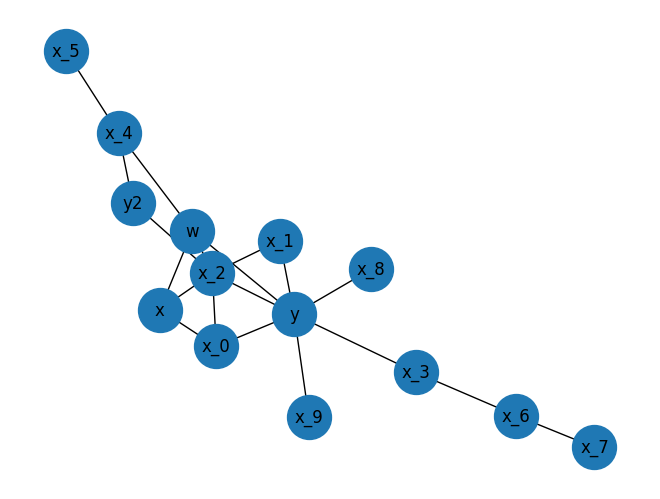

PositivePredictiveValue:  1.0
FalseDiscoveryRate:  0.21


In [ ]:
df = data6
causal_parents_real =[('x', 'w'), ('x_1', 'x_2'),('x_0', 'x'),('x_0', 'x_2'),('w', 'x_4'),('w', 'x_2'),('w', 'y'),
                      ('x_2', 'y2'),('x_2', 'y'),('y', 'x_3'),('x_4', 'x_5'),
                      ('x_3', 'x_6'),('x_6', 'x_7'),('y', 'x_8'),('x_9', 'y')]


causal_parents_predicted = build_causal_graph_multiple_covariates(df, plot=True)
PPV, FDR = get_metrics(causal_parents_predicted, causal_parents_real)